# Shuffling simulations

## Problem description

Consider a card shuffling process:

Take the card deck (52 cards) is split into 2 (26 cards).Put each half in a simple card-shuffling machine.

While there are cards in each half-deck, for the pair of bottom cards in each half-deck, pick one randomly.
Put the picked card at the bottom of the new deck.
Keep going until both half-decks have cards.

When only one half-deck remains, place all the remaining cards into the new deck in the same order as they are.

**Question:** How "*uniform*" is the resulting deck? How many shuffled are needed to achieve "*uniformness*"?

To evaluate "*uniformness*", consider the probability **P(i->j)** of the **i**-th card to end in the *j*-th position after the shuffle

The goal is to acheive **P(i->j) = 1/52 = 1.923%** for each **i** and **j**

**Solution**: Simulate card suffling. Visualise and evaluate the results.

## Utils

In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from shuffler import *
import time


def get_fsize_mb(path):  
    file_size_bytes = path.stat().st_size
    file_size_mb = file_size_bytes / (1024 * 1024)
    return file_size_mb

    
deck_size = 52

## Time simulation functions (with and without numba)

In [2]:
n_simulations = 100000
n_shuffles = 15

In [3]:
start_time = time.time()
run_shuffling_simulation_fast(n_simulations, n_shuffles, deck_size=deck_size)
fast_time = time.time() - start_time
print(
    f"Time for run_shuffling_simulation_fast({n_simulations}, {n_shuffles}) = {fast_time:.6f} seconds"
)

Time for run_shuffling_simulation_fast(100000, 15) = 1.413981 seconds


In [4]:
start_time = time.time()
run_shuffling_simulation_old(n_simulations, n_shuffles, deck_size=deck_size)
old_time = time.time() - start_time
print(
    f"Time for run_shuffling_simulation_old({n_simulations}, {n_shuffles}) = {old_time:.6f} seconds"
)

Time for run_shuffling_simulation_old(100000, 15) = 30.134898 seconds


In [11]:
print(f"speedup x {old_time/fast_time:.1f}")

speedup x 21.3


## Run simulations

### Old method

In [5]:
n_simulations = 100000
max_shuffles = 15
outcomes_list = [n_simulations * np.eye(deck_size, dtype=np.int64)]
for n_shuffles in tqdm(range(1, max_shuffles+1), initial=1, total=max_shuffles+1, file=sys.stdout):
    outcomes_list.append(run_shuffling_simulation_old(n_simulations, n_shuffles, deck_size=deck_size))

outcomes = np.stack(outcomes_list, axis=0)

out_filename = Path(f"outcomes_old_{n_simulations}_simulations.npz")
np.savez(
    out_filename,
    outcomes=outcomes
)

print(f"Created {out_filename} size: {get_fsize_mb(out_filename):.2f} MB")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:16<00:00, 17.10s/it]
Created outcomes_old_100000_simulations.npz size: 0.33 MB


### Fast (numba) method

In [6]:
n_simulations = 25000000
max_shuffles = 15
outcomes_list = [n_simulations * np.eye(deck_size, dtype=np.int64)]
for n_shuffles in tqdm(range(1, max_shuffles+1), initial=1, total=max_shuffles+1, file=sys.stdout):
    outcomes_list.append(run_shuffling_simulation_fast(n_simulations, n_shuffles, deck_size=deck_size))

outcomes = np.stack(outcomes_list, axis=0)

out_filename = Path(f"outcomes_fast_{n_simulations}_simulations.npz")
np.savez(
    out_filename,
    outcomes=outcomes
)

print(f"Created {out_filename} size: {get_fsize_mb(out_filename):.2f} MB")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:47<00:00, 19.18s/it]
Created outcomes_fast_25000000_simulations.npz size: 0.33 MB


## Load results

In [7]:
n_simulations = 1000000
method = "old"
in_filename = Path(f"outcomes_{method}_{n_simulations}_simulations.npz")
print(f"Loaded {in_filename} size: {get_fsize_mb(in_filename):.2f} MB")
outcomes = np.load(in_filename)["outcomes"]

Loaded outcomes_old_1000000_simulations.npz size: 0.29 MB


In [8]:
n_simulations = 25000000
method = "fast"
in_filename = Path(f"outcomes_{method}_{n_simulations}_simulations.npz")
print(f"Loaded {in_filename} size: {get_fsize_mb(in_filename):.2f} MB")
outcomes = np.load(in_filename)["outcomes"]

Loaded outcomes_fast_25000000_simulations.npz size: 0.33 MB


## Display results

The value at the row **i** and column **j** indicates how likely card **i** is to end up at position **j**

- Blue square indicates probability lower than 1/52 (uniform distribuion)

- Green square indicates probability close to 1/52 

- Blue square indicates probability higher than 1/52

Target: get uniform distribution where each probability is about **1.923%**

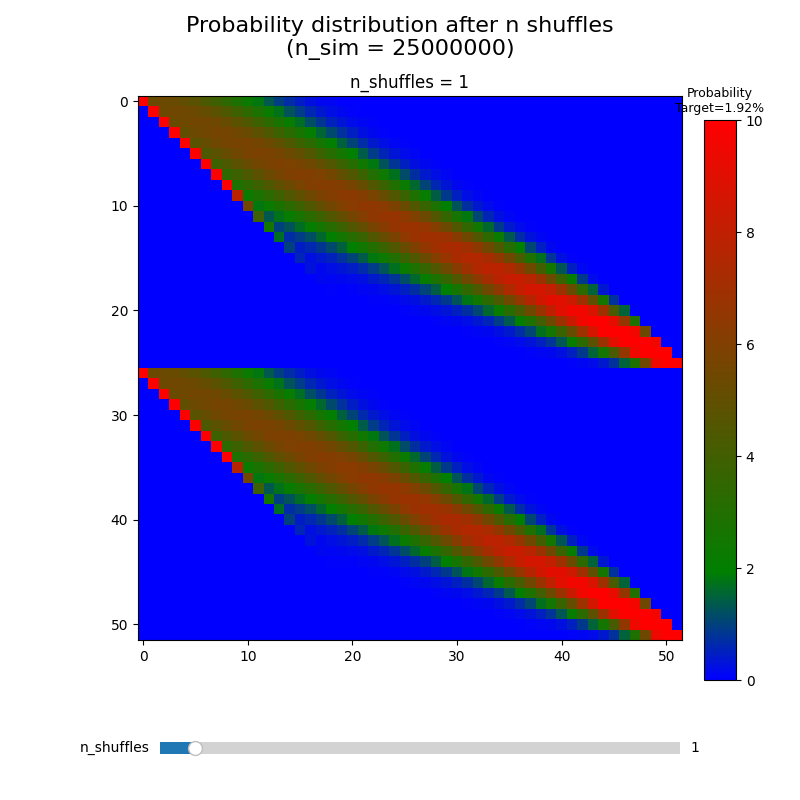

In [12]:
%matplotlib widget

try:
    plt.close()
except:
    pass
    
data = outcomes.astype(np.float64) / (n_simulations) * 100

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle(f"Probability distribution after n shuffles\n(n_sim = {n_simulations})", fontsize=16)
plt.subplots_adjust(bottom=0.2)  # Leave room for the slider

vmax = 10
# 0 = 0 , 1 = vmax, 1/52 = vmax/52
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "blue"), (vmax/52, "green"), (1, "red")]
)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cbar_ax.set_title(f"Probability\nTarget={1/52*100:.2f}%", fontsize=9)
fig.colorbar(ScalarMappable(cmap=custom_cmap, norm=Normalize(vmin=0, vmax=vmax)), cax=cbar_ax)

ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03])
initial_slice = 1
slider = Slider(ax_slider, 'n_shuffles', 0, data.shape[0] - 1, valinit=initial_slice, valstep=1)


def format_coord(x,y):
    i = int(round(y))
    j = int(round(x))
    return f"p({i+1} -> {j+1}) = "


def update(val):
    slice_idx = int(slider.val)
    img = data[slice_idx]
    ax.imshow(
        img, aspect='equal', origin='upper',
        cmap=custom_cmap, vmin=0, vmax=vmax
    )
    ax.set_title(f"n_shuffles = {slice_idx}")
    ax.format_coord = format_coord
    
slider.on_changed(update)

update(initial_slice)

plt.show()


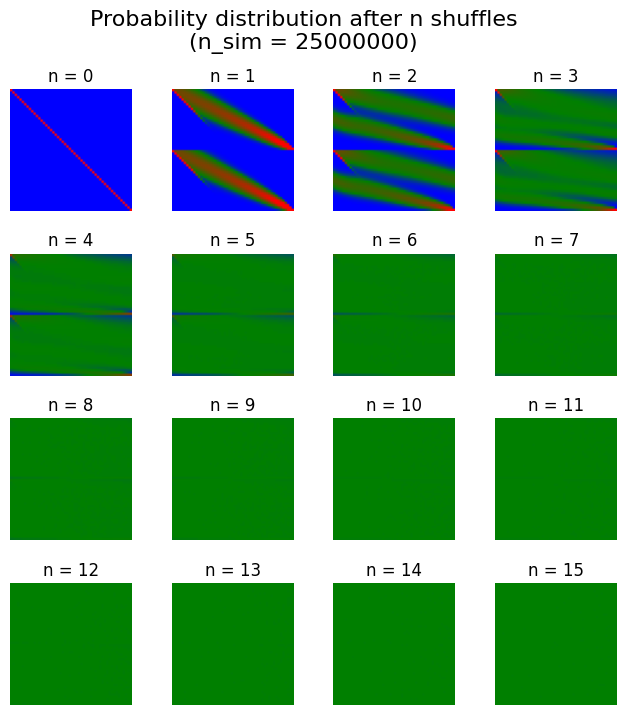

In [10]:
%matplotlib inline
try:
    plt.close()
except:
    pass
    
data = outcomes.astype(np.float64) / (n_simulations) * 100
n_rows = n_cols = int(np.ceil(np.sqrt(data.shape[0])))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8), gridspec_kw=dict(hspace=0.35))
fig.suptitle(f"Probability distribution after n shuffles\n(n_sim = {n_simulations})", fontsize=16)

for idx, ax in enumerate(axes.ravel()):
    ax.set_axis_off()
    if idx >= data.shape[0]: continue
    img = data[idx]
    ax.imshow(
        img, aspect='equal', origin='upper',
        cmap=custom_cmap, vmin=0, vmax=vmax
    )
    ax.set_title(f"n = {idx}")
    ax.format_coord = format_coord
    
plt.show()

## Conclusion

After 1 or 2 shuffles, deck is strongly non-uniform.

Uniformity improves after 3 - 5 shuffles.

It takes at least 9 - 10 shuffles to acheive true uniformity for the 1-st and the 27-th cards (top cards of the initial half-decks)